# Classification CNN on ImageNet dataset

In [ ]:
from plotting import imshow
import torch
import torchvision.models as models
from torchvision import transforms, datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
import cv2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # List class directories (e.g., n1443537)
        self.img_paths = []
        
        # Iterate over all class folders (directories named like 'n1443537')
        for class_idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)  # Path to class folder (e.g., n1443537)
            if os.path.isdir(class_folder):
                # Get all image file paths directly from the class folder
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    if os.path.isfile(img_path):  # Check if it's a file
                        self.img_paths.append((img_path, class_idx))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

# Define transformations to apply (resizing to 224x224, normalization)
transform = transforms.Compose([
    transforms.Resize(256),  # Resize shortest side to 256px
    transforms.CenterCrop(224),  # Crop to 224x224
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

# Use the CustomDataset
train_dataset = CustomImageNetDataset(root_dir='./train_imagenet', transform=transform)

# Create DataLoader for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# Example: Get one batch
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print shape of images in batch (should be [64, 3, 224, 224])
print(images.shape)


torch.Size([64, 3, 224, 224])


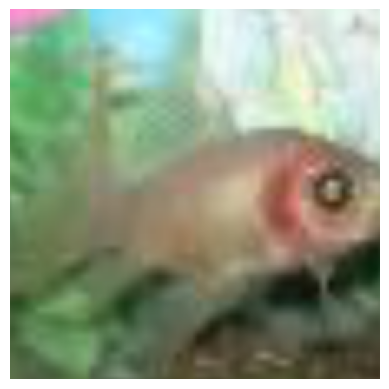

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert the image tensor to a NumPy array
# The images are in the shape (batch_size, 3, 224, 224), so we need to index the first image
image = images[0].numpy()

# Convert from (C, H, W) to (H, W, C)
image = np.transpose(image, (1, 2, 0))

# Denormalize the image (since we applied normalization in the transform)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean

# Clip the values to make sure they are between 0 and 1
image = np.clip(image, 0, 1)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis
plt.show()


# CNN construction

In [ ]:
# Input tensor(H,W,C) -> output tensor(C,H,W)
def yuv_rgb(array):
    new_array = array.numpy().astype(np.float32).copy()
    new_array = cv2.cvtColor(new_array, cv2.COLOR_YUV2RGB)
    
    return torch.tensor((new_array*255).astype(np.int32)).permute(2, 0, 1)

In [ ]:
class YUVImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None, bin_count=50):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # List class directories (e.g., n1443537)
        self.img_paths = []
        self.bin_count = bin_count
        self.bins = np.linspace(0, 1, self.bin_count)  # Bin edges for U and V channels

        # Iterate over all class folders (directories named like 'n1443537')
        for class_idx, class_name in enumerate(self.classes):
            class_folder = os.path.join(root_dir, class_name)  # Path to class folder (e.g., n1443537)
            if os.path.isdir(class_folder):
                # Get all image file paths directly from the class folder
                for img_name in os.listdir(class_folder):
                    img_path = os.path.join(class_folder, img_name)
                    if os.path.isfile(img_path):  # Check if it's a file
                        self.img_paths.append((img_path, class_idx))

    def __len__(self):
        return len(self.img_paths)

    def bin_labels(self, values):
        return np.digitize(values, self.bins) - 1  # Bin the U and V values to the bins

    def rgb2yuv(self, rgb_img):
        """Convert an RGB image to YUV format using OpenCV"""
        return cv2.cvtColor(np.array(rgb_img), cv2.COLOR_RGB2YUV)#.astype(np.int32)

    def __getitem__(self, idx):
        while True:  # Loop to find a valid image
            img_path, label = self.img_paths[idx]
            try:
                img = cv2.imread(img_path)
                if img is None:
                    raise ValueError(f"Corrupted or missing image: {img_path}")

                yuv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV).astype(np.int32)

                # Extract Y, U, and V channels
                Y_channel = (yuv_img[:, :, 0] / 255).astype(np.float32)
                U_channel = (yuv_img[:, :, 1] / 255).astype(np.float32)
                V_channel = (yuv_img[:, :, 2] / 255).astype(np.float32)

                # Expand dimensions
                Y_channel = np.expand_dims(Y_channel, axis=-1)
                U_channel = np.expand_dims(U_channel, axis=-1)
                V_channel = np.expand_dims(V_channel, axis=-1)

                # Binned U and V channels
                U_binned = self.bin_labels(U_channel)
                V_binned = self.bin_labels(V_channel)

                # Apply transformations if any
                if self.transform:
                    Y_channel = self.transform(Y_channel)
                    U_binned = self.transform(U_binned)
                    V_binned = self.transform(V_binned)

                return Y_channel, U_binned, V_binned, label

            except Exception as e:
                print(f"Skipping corrupted image: {img_path} | Error: {e}")
                if os.path.exists(img_path):
                    os.remove(img_path)  # Delete the corrupted image
                idx = (idx + 1) % len(self.img_paths)  # Move to the next image

In [ ]:
bin_count = 50
bins = np.linspace(0, 1, bin_count)
lookup_table = torch.zeros(50,dtype=torch.float32).to(device) 
for idx, value in enumerate(bins):
    lookup_table[idx] = value

def unbin_labels(bin_indices):
    return lookup_table[bin_indices]

In [ ]:
# Loading the RGB images
transform = None
yuv_dataset = YUVImageNetDataset(root_dir='./train_imagenet', transform=transform)
yuv_train_loader = DataLoader(yuv_dataset, batch_size=8, shuffle = True)

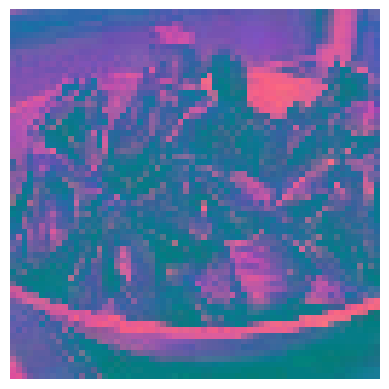

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10..258].


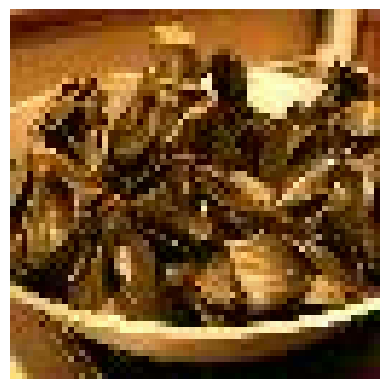

In [ ]:
for Y_channel, U_binned, V_binned, _ in yuv_train_loader:
    
    U_target_rec = unbin_labels(U_binned.clone().detach())
    V_target_rec = unbin_labels(V_binned.clone().detach())

    img_batch = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)
    
    imggg = img_batch[5]
    
    imshow(imggg)
    
    rgb_output = yuv_rgb(imggg.permute(1,2,0))

    imshow(rgb_output) 
    
    
    break

In [ ]:
import torch.nn.functional as F
class PretrainedClassificationCNN(nn.Module):
    def __init__(self, num_classes=50):
        super(PretrainedClassificationCNN, self).__init__()
        
        # Load the pretrained ResNet50 model
        resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        
        # Use ResNet50 without the fully connected layer (only the feature extractor part)
        self.encoder = nn.Sequential(
            resnet50.conv1,  # Initial Convolution
            resnet50.bn1,    # Batch Normalization
            resnet50.relu,   # ReLU activation
            resnet50.maxpool, # Maxpool layer
            resnet50.layer1, # ResNet layer1
            resnet50.layer2, # ResNet layer2
        #    resnet50.layer3, # ResNet layer3
        #    resnet50.layer4  # ResNet layer4
        )
        
        # 1x1 convolution to reduce the output size to [batch_size, num_classes, H, W]
        self.conv = nn.Conv2d(512, 512, kernel_size = 1)

        self.conv1x1_U = nn.Conv2d(512, num_classes, kernel_size=1)
        self.conv1x1_V = nn.Conv2d(512, num_classes, kernel_size=1)
        
    def forward(self, x):
        # Pass through ResNet layers
        x = self.encoder(x)
        
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
        
        # Apply 1x1 convolutions for U and V outputs directly
        u = self.conv1x1_U(x)
        v = self.conv1x1_V(x)
        
        # Global Average Pooling to get a fixed-size output [batch_size, num_classes]
        #u = F.adaptive_avg_pool2d(u, (1, 1))  # Shape will be [batch_size, num_classes, 1, 1]
        #v = F.adaptive_avg_pool2d(v, (1, 1))  # Shape will be [batch_size, num_classes, 1, 1]
        
        # Remove the extra dimensions

        #u = u.view(u.size(0), -1)  # Shape: [batch_size, num_classes]
        #v = v.view(v.size(0), -1)  # Shape: [batch_size, num_classes]

        return u, v


In [ ]:
bin_count = 50  # Number of bins for U and V channels
model = PretrainedClassificationCNN(num_classes=bin_count).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
num_epochs = 30
total_loss = []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for Y_channel, U_target, V_target, _ in yuv_train_loader:
        # Move data to device (e.g., GPU or CPU)
        Y_channel = Y_channel.permute(0, 3, 1, 2).to(device)  # (batch_size, 3, H, W)
        U_target = U_target.to(device)  # (batch_size, H, W)
        V_target = V_target.to(device)  # (batch_size, H, W)

        Y_channel_rgb = Y_channel.repeat(1, 3, 1, 1)  # Shape (batch_size, 3, H, W)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass: get predictions from the model
        U_pred, V_pred = model(Y_channel_rgb)

        U_target, V_target = U_target.permute(0, 3, 1, 2), V_target.permute(0, 3, 1, 2)
        
        
        # Compute loss for U and V channels
        loss_U = criterion(U_pred, U_target.squeeze(1))  # CrossEntropyLoss expects shape (N, C)
        loss_V = criterion(V_pred, V_target.squeeze(1))

        # Total loss: sum of U and V losses
        loss = loss_U + loss_V

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the running loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(yuv_train_loader):.4f}")

# Save the final model after training
torch.save(model.state_dict(), f"models/pretrainedclassification_{num_epochs}ep.pth")

Skipping corrupted image: ./train_imagenet\n03976657\n03976657_boxes.txt | Error: Corrupted or missing image: ./train_imagenet\n03976657\n03976657_boxes.txt
Skipping corrupted image: ./train_imagenet\n07753592\n07753592_boxes.txt | Error: Corrupted or missing image: ./train_imagenet\n07753592\n07753592_boxes.txt
Skipping corrupted image: ./train_imagenet\n03126707\n03126707_boxes.txt | Error: Corrupted or missing image: ./train_imagenet\n03126707\n03126707_boxes.txt
Skipping corrupted image: ./train_imagenet\n03662601\n03662601_boxes.txt | Error: Corrupted or missing image: ./train_imagenet\n03662601\n03662601_boxes.txt
Skipping corrupted image: ./train_imagenet\n02085620\n02085620_boxes.txt | Error: Corrupted or missing image: ./train_imagenet\n02085620\n02085620_boxes.txt
Skipping corrupted image: ./train_imagenet\n03584254\n03584254_boxes.txt | Error: Corrupted or missing image: ./train_imagenet\n03584254\n03584254_boxes.txt
Skipping corrupted image: ./train_imagenet\n03838899\n0383

In [ ]:
def converter(pred):
    softmax = nn.Softmax(dim = 1).to(device)
    probs = softmax(pred)
    _, ind = torch.topk(probs,1,1)
    return ind

In [ ]:
model.load_state_dict(torch.load(f"models/pretrainedclassification_{num_epochs}ep.pth"))

In [ ]:
for Y_channel, U_target, V_target, _ in train_loader:
    Y_channel, U_target, V_target = Y_channel.to(device), U_target.to(device), V_target.to(device)
    
    U_pred, V_pred = model(Y_channel.permute(0,3,1,2))
    
    conv_pred_U = converter(U_pred.cpu())
    conv_pred_V = converter(V_pred.cpu())

    pred_U_rec = unbin_labels(conv_pred_U.clone().detach())
    pred_V_rec = unbin_labels(conv_pred_V.clone().detach())

    reconstructed_pred = torch.cat([Y_channel.permute(0,3,1,2).cpu(),pred_U_rec.cpu(),pred_V_rec.cpu()],dim=1)

    U_target_rec = unbin_labels(U_target)
    V_target_rec = unbin_labels(V_target)

    reconstructed_img = torch.cat([Y_channel.cpu(),U_target_rec.cpu(),V_target_rec.cpu()],dim=3).permute(0,3,1,2)

    image_yuv = reconstructed_img[2]  
    image_yuv_pred = reconstructed_pred[2]

    # Need to resize first
    rgb_output = yuv_rgb(image_yuv.resize(32, 32,3))
    rgb_output_pred = yuv_rgb(image_yuv_pred.resize(32, 32,3))

    print(f"Filename: {fname[0]}")

    imshow(rgb_output) 
    imshow(rgb_output_pred) 
    
    
    break